# Kalman Filter Mean Reversion Strategy: EWA vs. EWC

<u>Goal:</u> Crear una estrategia de mean-reversion entre dos activos que puede que no esten cointegrados pero que fundamentalmente tiene sentido que durante un corto periodo de tiempo evolucione junto. 

Dinamicas del modelo: 


\begin{cases}
y_t = x_t \times \beta _t + \epsilon _t \\
\beta _t = \beta _ {t-1} + \omega _t
\end{cases}

- $\beta$ no va a ser tan volatil entre un dia y otro ya que estas controlando la varianza de la variable

- Regresion lineal se va a basar en toda la informacion observada anteriormente.

- Vamos a utilizar un <i>Z-Score modificado</i>: el moving average --> intercept de la regresion lineal (ver el intercept como la media del spread) y el moving standard deviation va a ser la varianza del error esperado entre el $y$ teorico y la observacion del precio, esto nos indica cuantas desviaciones estandar esta la observacion en cuanto a lo que podriamos esperar


## Update formulae

We observe price at instant $t$: 

$$ \hat{\beta}_{t|t} = \hat{\beta}_{t|t-1} + K_t (y_t - x_t \hat{\beta}_{t|t-1})$$

Using this we can have a formula of the forecast error between $\hat{\beta}_{t|t}$ and $\beta_t$

$$R_{t|t} = R_{t|t-1} - K_t x_t R_{t|t-1}$$

And then, __the forecast error at time $t$__
$$R_{t+1|t} = R_{t|t} + V_{\omega}$$


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import os

## Step 1: Retrieving data

We retrieve data for asset 1 and asset 2, here asset 1 will be EWA and asset 2 will be EWC. 
 __Daily prices for EWA and EWC__

In [2]:
df = pd.read_csv(r'/Users/educontreras/PycharmProjects/Quantitative-Finance/Algorithmic Trading - E. Chan/data/inputData_EWA_EWC.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d').dt.date  # remove HH:MM:SS
df.set_index('Date', inplace=True)

x = df['EWA']
y = df['EWC']

## Step 2: Manipulate data

We will add a constant to asset1 in order to accomodate possible offset/intercept in the regression.

__Now x has two columns: EWA price and 1s__

In [3]:
x = np.array(ts.add_constant(x))[:, [1, 0]]

Then we have to define the $\delta$ that will be responsible for the variance of the error in the betas. 

- $\delta = 1$ allows fastest changes in $\beta$
- $\delta = 0$ allows no change --> Traditional linear regression

In [4]:
delta = 0.0001

Then we will define the vector where we will have the measurement prediction: 

$$\hat{y}_t = x_t \times \hat{\beta}_{t|t-1}$$

In [7]:
yhat = np.full(y.shape[0], np.nan)
e = yhat.copy()
Q = yhat.copy()

We will define the rest of the variables: 
- R: Will contain the forecast error from t to t+1
- P: Will contain the expected estimation error in t knowing t measure
- $\beta$: dimension $N \times 2$ with $N$ the number of obervations.
- $V_{\omega}$: Error of hidden variable in updating time step. $2 \times 2$ matrix
- $V_{\epsilon}$: Measure error in linear regression. Real number

## Step 3: Initialize the data

For this recursive algorithm we only need to initialize: 

- $\beta_{0} = 0$: La prediccion del valor del state en $t = 0$ sera 0
- $R$
- Las respectivas varianzas. 


In [8]:
#Expected forecast error from t to t+1
R = np.zeros((2, 2))

#Expected forecast error in t once we have updated beta. Reduction of R by Kalman gain
P = R.copy()

#beta will contain the forecast in t for t+1. In this case is the same as Bt|t
beta = np.full((2, x.shape[0]), np.nan)

#Algorithm initializes beta at 0
beta[:, 0] = 0

### Variances Estimators
#Error at time updating
Vw = delta / (1 - delta) * np.eye(2)

#Linear regression white noise
Ve = 0.001

## Step 4: Put the algorithm in place

In [9]:
for t in range(len(y)):
    #We loop over the whole available period
    if t > 0:
        #First estimate of beta: is the last beta value
        beta[:, t] = beta[:, t - 1]
        
        R = P + Vw
    #Projection of the new measure y[t] into the subspace generated by last observations --> np.dot(x[t, :], beta[:, t])
    yhat[t] = np.dot(x[t, :], beta[:, t])
    
    
    Q[t] = np.dot(np.dot(x[t, :], R), x[t, :].T) + Ve
    #    print('Q[t]=', Q[t])

    # Observe y(t)
    e[t] = y[t] - yhat[t]  # measurement prediction error
    #    print('e[t]=', e[t])
    #    print('SECOND: yhat[t]=', yhat[t])

    K = np.dot(R, x[t, :].T) / Q[t]  # Kalman gain
    #    print(K)

    beta[:, t] = beta[:, t] + np.dot(K, e[t])  # State update. Equation 3.11
    #    print(beta[:, t])

    # P=R-np.dot(np.dot(K, x[t, :]), R) # State covariance update. Euqation 3.12
    P = R - np.dot(np.outer(K, x[t, :]), R) 

APR=0.305703 Sharpe=3.314831


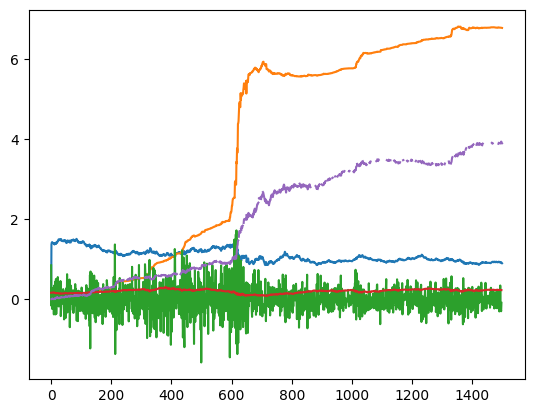

In [10]:

plt.plot(beta[0, :])
plt.plot(beta[1, :])
plt.plot(e[2:])
plt.plot(np.sqrt(Q[2:]))


# Entras cuando la diferencia entre el valor obtenido en t y el valor de yhat este muy por debajo de lo esperado --> lo
#esperado esta medido en terminos del expected variance en la prediccion de y
longsEntry = e < -np.sqrt(Q)
longsExit = e > 0

shortsEntry = e > np.sqrt(Q)
shortsExit = e < 0

numUnitsLong = np.zeros(longsEntry.shape)
numUnitsLong[:] = np.nan

numUnitsShort = np.zeros(shortsEntry.shape)
numUnitsShort[:] = np.nan

numUnitsLong[0] = 0
numUnitsLong[longsEntry] = 1
numUnitsLong[longsExit] = 0
numUnitsLong = pd.DataFrame(numUnitsLong)
numUnitsLong.fillna(method='ffill', inplace=True)

numUnitsShort[0] = 0
numUnitsShort[shortsEntry] = -1
numUnitsShort[shortsExit] = 0
numUnitsShort = pd.DataFrame(numUnitsShort)
numUnitsShort.fillna(method='ffill', inplace=True)

numUnits = numUnitsLong + numUnitsShort
positions = pd.DataFrame(np.tile(numUnits.values, [1, 2]) * ts.add_constant(-beta[0, :].T)[:, [1,
                                                                                               0]] * df.values)  # [hedgeRatio -ones(size(hedgeRatio))] is the shares allocation, [hedgeRatio -ones(size(hedgeRatio))].*y2 is the dollar capital allocation, while positions is the dollar capital in each ETF.
pnl = np.sum((positions.shift().values) * (df.pct_change().values), axis=1)  # daily P&L of the strategy
ret = pnl / np.sum(np.abs(positions.shift()), axis=1)
(np.cumprod(1 + ret) - 1).plot()
print('APR=%f Sharpe=%f' % (np.prod(1 + ret) ** (252 / len(ret)) - 1, np.sqrt(252) * np.mean(ret) / np.std(ret)))
# APR=0.313225 Sharpe=3.464060
